In [1]:
!pip install opencv-python numpy tensorflow scikit-learn matplotlib wandb tdqm wurlitzer pandas plotly pyarrow

  Obtaining dependency information for opencv-python from https://files.pythonhosted.org/packages/d9/64/7fdfb9386511cd6805451e012c537073a79a958a58795c4e602e538c388c/opencv_python-4.9.0.80-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/4e/53/14405a47292b59235d811a2af8634aba188ccfd1a38ef4b8042f3447d79a/scikit_learn-1.4.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for wandb from https://files.pythonhosted.org/packages/8b/8d/bb05a4ecdeac6b2256d98ac10bae8723af5d7a8c1a4c2384b3ae0f80370e/wandb-0.16.6-py3-none-any.whl.metadata
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for wurlitzer from https://files.pythonhosted.org/packages/28/69/9d913bc2f85305c4eaf078fb22fd4828182b33189c1e78f2256ae27eaacb/wurlitzer-3.0.3-py3-none-any.whl.metadata
  Obtaining dependency information for pandas from http

In [2]:
import os
import math
import pandas as pd
import numpy as np
#Load parquet data into dataset_parquet for training.
import tensorflow as tf
from tensorflow import keras
from keras.regularizers import l2
from glob import glob
from tqdm import tqdm
from collections import Counter
import random
import time
import wandb

2024-04-24 20:00:24.084302: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-24 20:00:24.109102: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-24 20:00:24.109123: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-24 20:00:24.109138: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-24 20:00:24.113808: I tensorflow/core/platform/cpu_feature_g

In [3]:
class CONFIG:
    # root = os.path.join("/", "kaggle", "input", "asl-signs") 
    # root = os.path.join(".")
    root = os.path.join(".")
    #root = os.path.join("..", "data", "asl-signs")
    DATA_LIMIT = 2000
    BATCH_SIZE = 32
    VIDEO_LENGTH = 36
    TRAIN_VAL_SPLIT = 0.8
    WANDB_RUN = "mediapipe-asl-dataset"


In [4]:
LIPS_IDXS0 = np.array([
        61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
        291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
        78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
        95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
    ])


EYE_LEFT = np.array([33, 7, 246, 161, 160, 159, 158, 157, 173, 133, 155, 154, 153, 145, 144, 163, 471, 470, 469, 472])


EYE_RIGHT = np.array([362, 398, 384, 385, 386, 387, 388, 466, 263, 249, 390, 373, 374, 380, 381, 382, 476, 475, 474, 477])
# Landmark indices in original data
LEFT_HAND_IDXS0 = np.arange(468,489)
RIGHT_HAND_IDXS0 = np.arange(522,543)
LEFT_POSE_IDXS0 = np.array([502, 504, 506, 508, 510])
RIGHT_POSE_IDXS0 = np.array([503, 505, 507, 509, 511])


LIPS_END = len(LIPS_IDXS0)
EYE_LEFT_END = LIPS_END + len(EYE_LEFT)
EYE_RIGHT_END = EYE_LEFT_END + len(EYE_RIGHT)
LEFT_HAND_END = EYE_RIGHT_END + len(LEFT_HAND_IDXS0)
RIGHT_HAND_END = LEFT_HAND_END + len(RIGHT_HAND_IDXS0)
LEFT_POSE_END = RIGHT_HAND_END + len(LEFT_POSE_IDXS0)
RIGHT_POSE_END = LEFT_POSE_END + len(RIGHT_POSE_IDXS0)

print("LIPS : ",len(LIPS_IDXS0))
print("EYE_LEFT : ",len(EYE_LEFT))
print("EYE_RIGHT : ",len(EYE_RIGHT))
print("LEFT_HAND : ",len(LEFT_HAND_IDXS0))
print("RIGHT_HAND : ",len(RIGHT_HAND_IDXS0))
print("LEFT_POSE : ",len(LEFT_POSE_IDXS0))
print("RIGHT_POSE : ",len(RIGHT_POSE_IDXS0))

all_selection = np.concatenate([LIPS_IDXS0, EYE_LEFT, EYE_RIGHT, LEFT_HAND_IDXS0, RIGHT_HAND_IDXS0, LEFT_POSE_IDXS0, RIGHT_POSE_IDXS0])
print(len(all_selection))

LIPS :  40
EYE_LEFT :  20
EYE_RIGHT :  20
LEFT_HAND :  21
RIGHT_HAND :  21
LEFT_POSE :  5
RIGHT_POSE :  5
132


In [5]:
def update_mean (values, mean, cnt):
    if np.any(np.isnan(values)):
        return mean, cnt
    
    mean += np.sum(values, axis=0)
    cnt += values.shape[0]
    return mean, cnt

def update_std(values, mean, std):
    if np.any(np.isnan(values)):
        return std
    
    std += np.sum((values - mean)**2, axis=0)
    return std

In [6]:
#this code sorts out a parquet files and rearrange the order to pose,face, left-hand, right-hand
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import plotly.graph_objs as go
from sklearn.model_selection import train_test_split
import plotly.io as pio

def visualize_keypoints(frames : np.ndarray, point_size : int):
    if len(frames.shape) == 1:
        frames = np.array([frames])
    
    for frame in frames:
        frame = frame.reshape(-1, 3)
        sizes = point_size * np.ones(frame.shape[0])

        fig = go.Figure(data=go.Scatter(x=frame[:,0], y=2.5 - frame[:,1], mode='markers',
                                        marker=dict(
                                            size=sizes
                                            )))

    # Customize the layout
    fig.update_layout(title='visualization of human keypoints',
                        xaxis_title='',
                        yaxis_title='',
                        width=1000,
                        height=1600)

    fig.update_xaxes(range=[-0.2, 1.4])  # Set x-axis range from 0 to 6
    fig.update_yaxes(range=[0, 2.5])  # Set y-axis range from 10 to 20

    # Show the plot
    fig.show()

def process_parquet2(ds, idxes = None):
    ret = []    
    frame_size = 543
    it = len(ds) // frame_size
    assert it == len(ds) / frame_size
    
    for i in range(it):
        vals = ds.iloc[ i * frame_size : (i + 1 ) * frame_size ]        
        
        if idxes is not None:          
            vals = ds.iloc[idxes]
                        
        ret.append(np.array(vals[["x","y", "z"]]))
        
    return np.array(np.array(ret))

In [7]:
class Groups:
    def __init__(self):
        self.starts = []
        self.id_2_label = {}
        self.means = []
        self.cnts = []
        self.stds = []

    def add(self, start, name):
        self.id_2_label[len(self.starts)] = name
        self.starts.append(start)
        self.means.append(np.array([0.0,0.0,0.0]))
        self.cnts.append(0)
        self.stds.append(np.array([0.0,0.0,0.0]))
        
    def reset(self):
        for i in range(len(self.means)):
            self.means[i] = np.array([0,0,0])
            self.cnts[i] = 0
            self.stds[i] = np.array([0,0,0])
            
    def __str__(self):
        s = ""
        for i in range(len(self.starts)):
            s += f"name={self.id_2_label[i]} idxes = ({self.starts[i][0]}, {self.starts[i][1]}), mu={self.means[i]}, std = {self.stds[i]}\n"
        
        return s
    
#custom class to load data from Parquet files for training ML models.
class ParquetDatasetCached(keras.utils.Sequence):
    def __init__(self, dataset_folder, csv_file : str, groups : Groups=None, batch_size=CONFIG.BATCH_SIZE, 
                 data_limit :int= CONFIG.DATA_LIMIT, check_if_file_exists = True, 
                 frame_length :int = CONFIG.VIDEO_LENGTH, split : str = "train", 
                 train_val_split : float = CONFIG.TRAIN_VAL_SPLIT, sort_by_counts : bool = True, 
                 idxes=None, **kwargs):
        super().__init__(**kwargs)
        #taking keras sequence for .fit(), .evaluate(), .predict() methods
        #load csv - it has the path to parquet file, and another to store label
        self.cached_Y = None
        self.cached_X = None
        self.csv_path = csv_file
        self.root_folder = dataset_folder
        self.batch_size = batch_size
        #optional pre-processing function to the parquet files.
        self.group = groups
        
        self.csv_data = pd.read_csv(self.csv_path)
        
        self.all_files = []
        self.not_exists = []
        self.frame_length = frame_length

        for path, label in tqdm(list(zip(self.csv_data["path"], self.csv_data["sign"]))):
            prop_path = os.path.join(self.root_folder, path)
            
            if check_if_file_exists:
                if os.path.exists(prop_path):
                    self.all_files.append((prop_path, label))
                else:
                    self.not_exists.append(prop_path)
            else:
                self.all_files.append((prop_path, label))
                
                    
        self.all_files = np.array(self.all_files)
        self.unique_labels = np.unique(self.all_files[:, 1])
        self.label_2_id = { key : i for i, key in enumerate(self.unique_labels)}
    
        # sort the values by popularity
        if sort_by_counts:
            cnt = Counter(self.all_files[:, 1])
            vals = []
            
            for i,row in enumerate(self.all_files):
                vals.append((int(1e6 * cnt[row[1]] + self.label_2_id [row[1]]),i))
            
            vals = np.array(sorted(vals)[::-1])
            self.all_files = self.all_files[vals[:,1]]

        
        if data_limit < 0:
            train_ds, val_ds = train_test_split(self.all_files, train_size=train_val_split, random_state=42)
        else:
            train_ds, val_ds = train_test_split(self.all_files[:data_limit], train_size=train_val_split, random_state=42)
            self.unique_labels = np.unique(self.all_files[:data_limit, 1])
            self.label_2_id = { key : i for i, key in enumerate(self.unique_labels)}
            
        if split.lower() == "train":
            self.dataset = train_ds
            
        elif split.lower() == "val":
            self.dataset = val_ds 
            
        else:
            raise Exception("please specify split to be either train or val")
            
        self.cache_data(idxes)
        self.calculate_props_for_groups()

    def normalize_data_points(self):
        for i in tqdm(range(len(self.cached_X)), desc="normalizing"):
            self.preprocess(self.cached_X[i])
            
                   
    def getGroups(self):
        return self.group
    
    def select(self, frames):
        current_length, num_features, _ = frames.shape
    
        if current_length >= CONFIG.VIDEO_LENGTH:
                # TODO: a better than uniform value ? Could place gaussian in the middle
                random_start = random.randint(0, current_length - CONFIG.VIDEO_LENGTH)
                return frames[random_start : (random_start + CONFIG.VIDEO_LENGTH)]
            
        # padd the video to contain zeros 
        return np.concatenate([frames, np.zeros((CONFIG.VIDEO_LENGTH - current_length, num_features,3))], axis=0)

    def preprocess(self, raw_frames):
        select_frames = raw_frames
        t = select_frames.shape[0]
        
        for i in range(t):   
            for j in range(len(self.group.starts)):
                start = self.group.starts[j] 
                mean, std = self.group.means[j], self.group.stds[j]
                region = select_frames[i, start[0] : start[1], :]                
                region = (region - mean) / std
                region = np.nan_to_num(region)                
                select_frames[i, start[0] : start[1]] = region
                
                
        return select_frames
        
            
    def cache_data(self, idxes):
        self.cached_X, self.cached_Y = [], []
        
        pb = tqdm(range(len(self.dataset)), desc="Cacheing")

        for i in pb:
            
            path, label = self.dataset[i]
            df = pd.read_parquet(path)
                        
            one_hot_encoded_label = np.zeros(len(self.unique_labels))
            one_hot_encoded_label[self.label_2_id[label]] = 1

            self.cached_X.append(process_parquet2(df, idxes=idxes))
            self.cached_Y.append(one_hot_encoded_label)     
            
        
    def calculate_props_for_groups(self):
        
        if self.group is None:
            return 
                            
        for frames in tqdm(self.cached_X, desc="calculating means"):
            for frame in frames:
                for i in range(len(self.group.starts)):
                    start = self.group.starts[i]
                    mean = self.group.means[i]
                    cnts = self.group.cnts[i]
                    
                    feature = frame[start[0]:start[1]]
                    
                    self.group.means[i], self.group.cnts[i] = update_mean(feature, mean, cnts)                   
 
        
        # set the means 
        for i in range(len(self.group.starts)):            
            self.group.means[i] = self.group.means[i] / self.group.cnts[i]
            
        # calculate the standard deviations
        for frames in tqdm(self.cached_X, desc="calculating std"):
            for frame in frames:
                for i in range(len(self.group.starts)):
                    start = self.group.starts[i]
                    std = self.group.stds[i]
                    mean = self.group.means[i]                    
                    feature = frame[start[0]:start[1]]
                    
                    self.group.stds[i] = update_std(feature, mean=mean, std=std)                   
 
        # set the standard deviations 
        for i in range(len(self.group.starts)):            
            self.group.stds[i] = np.sqrt(self.group.stds[i] / self.group.cnts[i])
  
    def set_group(self, group):
        self.group = group

    def __len__(self):
        # Assuming each Parquet file should be one batch; adjust if necessary
        return len(self.dataset)

    def __getitem__(self, idx):
        traj = self.select(self.cached_X[idx])
        t = traj.shape[0]
        return traj.reshape(t, -1), self.cached_Y[idx]                
        
    def on_epoch_end(self):
        # Shuffle files for the next epoch
        np.random.shuffle(self.dataset)


    
groups = Groups()
groups.add((0, LIPS_END), "lips")
groups.add((LIPS_END, EYE_LEFT_END), "left eye")
groups.add((EYE_LEFT_END, EYE_RIGHT_END), "right eye")
groups.add((EYE_RIGHT_END, LEFT_HAND_END), "left hand")
groups.add((LEFT_HAND_END, RIGHT_HAND_END), "right hand")
groups.add((RIGHT_HAND_END, LEFT_POSE_END), "left pose")
groups.add((LEFT_POSE_END, RIGHT_POSE_END), "right pose")

# Usage example
parquet_folder_path = CONFIG.root
train_dataset_parquet = ParquetDatasetCached(parquet_folder_path, csv_file = os.path.join(CONFIG.root, "train.csv"), 
                                 batch_size=CONFIG.BATCH_SIZE, data_limit=CONFIG.DATA_LIMIT, groups=groups,
                                             check_if_file_exists = False,
                                             split="train", idxes= all_selection)
train_dataset_parquet.normalize_data_points()

val_dataset_parquet = ParquetDatasetCached(parquet_folder_path, csv_file = os.path.join(CONFIG.root, "train.csv"), 
                                 batch_size=CONFIG.BATCH_SIZE, data_limit=CONFIG.DATA_LIMIT,
                                 check_if_file_exists= False,
                                 split="val",idxes= all_selection)
val_dataset_parquet.set_group(train_dataset_parquet.group)
val_dataset_parquet.normalize_data_points()

print(f"cardinality of train : {len(train_dataset_parquet)}, cardinality of validation : {len(val_dataset_parquet)}")

normalizing: 100%|██████████| 400/400 [00:01<00:00, 370.31it/s]

cardinality of train : 1600, cardinality of validation : 400


In [8]:
print(groups)

name=lips idxes = (0, 40), mu=[ 0.46837713  0.48302917 -0.02288619], std = [0.07567185 0.07805494 0.01595569]
name=left eye idxes = (40, 60), mu=[0.3991533  0.42728534 0.00753501], std = [0.13361506 0.14249471 0.03310135]
name=right eye idxes = (60, 80), mu=[ 0.51717346  0.40728644 -0.00183984], std = [0.09961183 0.13192261 0.04502668]
name=left hand idxes = (80, 101), mu=[ 0.64549218  0.60715568 -0.05593578], std = [0.15745084 0.19082723 0.06481537]
name=right hand idxes = (101, 122), mu=[ 0.32559969  0.59123747 -0.06171813], std = [0.14304286 0.17530013 0.05818096]
name=left pose idxes = (122, 127), mu=[ 0.87917387  0.94527561 -1.30689645], std = [0.18371726 0.28708228 0.70052876]
name=right pose idxes = (127, 132), mu=[ 0.1245269   0.93955634 -1.58225958], std = [0.17150104 0.3138634  0.96991489]



In [9]:
nans = False

for x, y in tqdm(train_dataset_parquet):
    nans |= np.any(np.isnan(x))
    if nans:
        print("SAD : ")
        break

for x, y in tqdm(val_dataset_parquet):
    nans |= np.any(np.isnan(x))
    if nans:    
        print("SAD : ")
        break


100%|██████████| 400/400 [00:00<00:00, 76028.53it/s]


In [10]:
print(groups)

name=lips idxes = (0, 40), mu=[ 0.46837713  0.48302917 -0.02288619], std = [0.07567185 0.07805494 0.01595569]
name=left eye idxes = (40, 60), mu=[0.3991533  0.42728534 0.00753501], std = [0.13361506 0.14249471 0.03310135]
name=right eye idxes = (60, 80), mu=[ 0.51717346  0.40728644 -0.00183984], std = [0.09961183 0.13192261 0.04502668]
name=left hand idxes = (80, 101), mu=[ 0.64549218  0.60715568 -0.05593578], std = [0.15745084 0.19082723 0.06481537]
name=right hand idxes = (101, 122), mu=[ 0.32559969  0.59123747 -0.06171813], std = [0.14304286 0.17530013 0.05818096]
name=left pose idxes = (122, 127), mu=[ 0.87917387  0.94527561 -1.30689645], std = [0.18371726 0.28708228 0.70052876]
name=right pose idxes = (127, 132), mu=[ 0.1245269   0.93955634 -1.58225958], std = [0.17150104 0.3138634  0.96991489]



101 122 127
len(frames) = 35


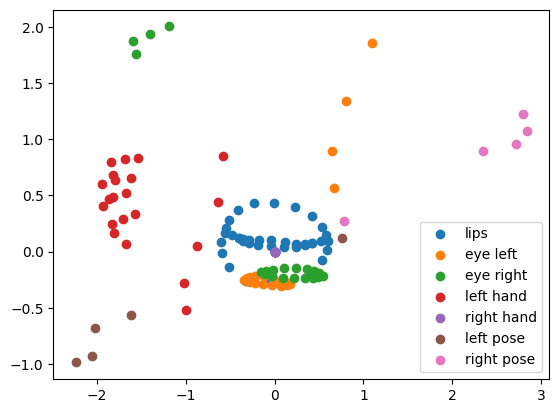

In [11]:
import matplotlib.pyplot as plt 

i = 1
LIPS_END = len(LIPS_IDXS0)
EYE_LEFT_END = LIPS_END + len(EYE_LEFT)
EYE_RIGHT_END = EYE_LEFT_END + len(EYE_RIGHT)
LEFT_HAND_END = EYE_RIGHT_END + len(LEFT_HAND_IDXS0)
RIGHT_HAND_END = LEFT_HAND_END + len(RIGHT_HAND_IDXS0)
LEFT_POSE_END = RIGHT_HAND_END + len(LEFT_POSE_IDXS0)
RIGHT_POSE_END = LEFT_POSE_END + len(RIGHT_POSE_IDXS0)

print(LEFT_HAND_END, RIGHT_HAND_END,LEFT_POSE_END)

frames = train_dataset_parquet.cached_X[i]
print(f"len(frames) = {len(frames)}")

frame = train_dataset_parquet.cached_X[0][0]

plt.scatter(frame[:LIPS_END, 0], frame[:LIPS_END, 1], label="lips")
plt.scatter(frame[LIPS_END:EYE_LEFT_END, 0], frame[LIPS_END:EYE_LEFT_END, 1], label="eye left")
plt.scatter(frame[EYE_LEFT_END:EYE_RIGHT_END,0], frame[EYE_LEFT_END:EYE_RIGHT_END, 1], label="eye right")
plt.scatter(frame[EYE_RIGHT_END:LEFT_HAND_END,0], frame[EYE_RIGHT_END:LEFT_HAND_END, 1], label="left hand")
plt.scatter(frame[LEFT_HAND_END:RIGHT_HAND_END, 0], frame[LEFT_HAND_END:RIGHT_HAND_END, 1], label="right hand")
plt.scatter(frame[RIGHT_HAND_END:LEFT_POSE_END, 0], frame[RIGHT_HAND_END:LEFT_POSE_END, 1], label="left pose")
plt.scatter(frame[LEFT_POSE_END:RIGHT_POSE_END, 0], frame[LEFT_POSE_END:RIGHT_POSE_END, 1], label="right pose")

plt.legend()
plt.show()

In [12]:
x, y = next(iter(train_dataset_parquet))
X_shape, Y_shape = x.shape, y.shape

In [13]:
x

array([[-0.55905635,  0.1629133 ,  1.03044723, ...,  2.72012163,
         0.95555742,  0.22947643],
       [-0.55905635,  0.1629133 ,  1.03044723, ...,  2.72012163,
         0.95555742,  0.22947643],
       [-0.55905635,  0.1629133 ,  1.03044723, ...,  2.72012163,
         0.95555742,  0.22947643],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [14]:
def dataset_train_generator():
    # Instantiate your existing dataset loader

    for i in range(len(train_dataset_parquet)):
        X_batch, Y_batch = train_dataset_parquet[i]
        yield X_batch, Y_batch
        
def dataset_val_generator():
    # Instantiate your existing dataset loader

    for i in range(len(val_dataset_parquet)):
        X_batch, Y_batch = val_dataset_parquet[i]
        yield X_batch, Y_batch        


train_dataset = tf.data.Dataset.from_generator(
    lambda: dataset_train_generator(),
    output_types=(tf.float32, tf.float32),  # Adjust types based on your actual data
    output_shapes=(X_shape, Y_shape)
).prefetch(tf.data.AUTOTUNE).batch(CONFIG.BATCH_SIZE)

val_dataset = tf.data.Dataset.from_generator(
    lambda: dataset_val_generator(),
    output_types=(tf.float32, tf.float32),  # Adjust types based on your actual data
    output_shapes=(X_shape, Y_shape)
).prefetch(tf.data.AUTOTUNE).batch(CONFIG.BATCH_SIZE)

2024-04-24 20:01:12.372195: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22462 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


In [15]:
els = np.array([0])
for x,y in tqdm(train_dataset):
    break 
    
x

0it [00:00, ?it/s]


<tf.Tensor: shape=(32, 36, 396), dtype=float32, numpy=
array([[[-0.55905634,  0.1629133 ,  1.0304472 , ...,  2.7201216 ,
          0.9555574 ,  0.22947644],
        [-0.55905634,  0.1629133 ,  1.0304472 , ...,  2.7201216 ,
          0.9555574 ,  0.22947644],
        [-0.55905634,  0.1629133 ,  1.0304472 , ...,  2.7201216 ,
          0.9555574 ,  0.22947644],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[-1.4844216 , -0.5923233 ,  1.0971457 , ..., -1.4787697 ,
          0.81079257,  0.04312035],
        [-1.4844216 , -0.5923233 ,  1.0971457 , ..., -1.4787697 ,
          0.81079257,  0.04312035],
        [-1.4844216 , -0.5923233 ,  1.0971457 , ..., -1.4787697 ,
          0.81079257,  0.04312035],
        ...,

50it [00:00, 256.86it/s]


(32, 36, 396) (32, 5)
Iterating through dataset took : 0.1963s


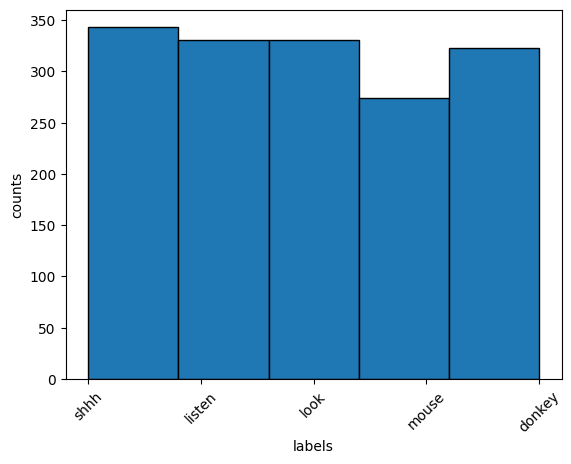

In [16]:
start = time.time()
isnans =False

id2label = {v : k for k,v in train_dataset_parquet.label_2_id.items()}

f = True
labels_batches = []
for el in tqdm(train_dataset):
    if f:
        print(el[0].shape, el[1].shape)
        f = False

    ls = np.argmax(el[1], axis=1)
    for l in ls:
        labels_batches.append(id2label[l])
    
    isnans |= np.any(np.isnan(el[0]))
    if isnans:
        print("FOUND NAN!")
        break

print(f"Iterating through dataset took : {round( time.time() - start , 4)}s")
plt.hist(labels_batches, bins=len(np.unique(labels_batches)), edgecolor="black")
plt.xlabel('labels')
plt.ylabel('counts')
plt.title('')

# Rotate x-axis ticks
plt.xticks(rotation=45)
plt.savefig("histogram.png")
plt.show()

In [17]:
from collections import defaultdict

c = defaultdict(list)
alltimes = []


for i in tqdm(range(len(train_dataset_parquet.cached_X))):
    x,y = train_dataset_parquet.cached_X[i], train_dataset_parquet.cached_Y[i]
    c[np.argmax(y)].append(x.shape[0])
    alltimes.append(x.shape[0])
    

100%|██████████| 1600/1600 [00:00<00:00, 224069.66it/s]


In [18]:
print(id2label)
no_cls = len(id2label)
fs = CONFIG.VIDEO_LENGTH

{0: 'donkey', 1: 'listen', 2: 'look', 3: 'mouse', 4: 'shhh'}


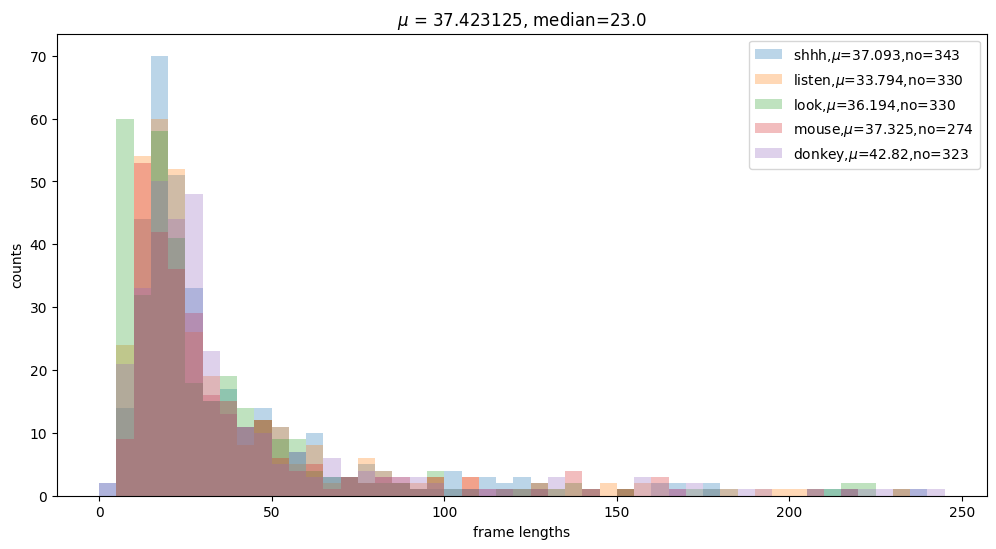

In [19]:

plt.figure(figsize=(12, 6))
ks = list(c.keys())

for k in ks:
    lengths = c[k]
    
    plt.title(f"$\mu$ = {np.mean(alltimes)}, median={np.median(alltimes)}")
    plt.hist(lengths, bins=np.arange(0, 250, 5), label=f"{id2label[k]},$\mu$={round(np.mean(lengths),3)},no={len(lengths)}", alpha=0.3)
    plt.xlabel("frame lengths")
    plt.ylabel("counts")


plt.legend()
plt.savefig("length distribution.png")
plt.show()

# Train experiment

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, LeakyReLU
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import backend as K
from wandb.keras import WandbMetricsLogger
from keras.callbacks import Callback
import tensorflow as tf
import wandb


class CosineAnnealingLearningRateScheduler(Callback):
    def __init__(self, max_lr, min_lr, T_max):
        super(CosineAnnealingLearningRateScheduler, self).__init__()
        self.max_lr = max_lr  # Maximum learning rate (i.e., start learning rate)
        self.min_lr = min_lr  # Minimum learning rate
        self.T_max = T_max    # Specifies the number of epochs per cycle
        self.t = 0            # Current epoch

    def on_epoch_begin(self, epoch, logs=None):
        self.t += 1
        cos = np.cos(np.pi * (self.t % self.T_max) / self.T_max)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + cos)

        keras.backend.set_value(self.model.optimizer.lr, lr)

def keras_train(model, filepath : str, max_lr = 1e-4, min_lr = 5e-5, T_max=51, epochs=100, run_name="",
                mediapipe_features = "all", USE_WANDB=True): 
    
    
    checkpoint = keras.callbacks.ModelCheckpoint(filepath,
                                                 monitor="val_categorical_accuracy",
                                                 verbose=0,
                                                 save_best_only=True,
                                                 mode="max",
                                                 save_freq="epoch")
    
    cosine_annealer = CosineAnnealingLearningRateScheduler(max_lr=max_lr,
                                                           min_lr=min_lr,
                                                           T_max=T_max)
    
    #Adam Optimizer - fixed learning rate.
    adam_optimizer = tf.keras.optimizers.Adam(learning_rate=max_lr, weight_decay=1e-5, clipnorm=1.)

    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False,label_smoothing=0.2)
    model.compile(optimizer=adam_optimizer, loss=loss, metrics=['categorical_accuracy'])
    
    
    callbacks  = [checkpoint, cosine_annealer]
    
    if USE_WANDB:
        wandb.init(project=CONFIG.WANDB_RUN,
                        name=run_name,
                        notes="Model summary : \n" + str(model),
                        config={"max_lr" : max_lr, 
                                "min_lr" : 5e-5, 
                                "scheduler" : "cosineAnnealer", 
                                "epochs" : epochs, 
                                "T_max" : T_max, 
                                "train_size" : len(train_dataset_parquet.dataset),
                                "val_size" : len(val_dataset_parquet.dataset),
                                "unique_classes" : len(train_dataset_parquet.unique_labels), 
                                "video_length" : CONFIG.VIDEO_LENGTH,
                                "features" : mediapipe_features
                                })
        callbacks.append(WandbMetricsLogger())


    history = model.fit(train_dataset, epochs=epochs, validation_data = val_dataset, callbacks=callbacks)
    
    if USE_WANDB:      
        wandb.finish()
    
    return history

# LSTM

In [21]:
model = Sequential()
#x,y,z -> y,z as the input shape
model.add(LSTM(16, return_sequences=False, input_shape=X_shape,
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(256, activation='gelu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))

model.summary()

"""
keras_train(model, filepath=os.path.join("models", f"RK-LSTM16-LR-Dense256-fs={fs}-cls={no_cls}.tf"),
            run_name=f"RK-LSTM16-LR-Dense256-fs={fs}-cls={no_cls}",
            max_lr=1e-4,
            min_lr=2.5e-5,
            T_max=101,
            epochs=200,
            mediapipe_features="reduced-LipsEyesHandsPose-scaled",
            USE_WANDB=True)
"""

2024-04-24 20:01:51.274867: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 16)                26432     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16)                0         
                                                                 
 dense (Dense)               (None, 256)               4352      
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 32069 (125.27 KB)
Trainable params: 32069 (125.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


'\nkeras_train(model, filepath=os.path.join("models", f"RK-LSTM16-LR-Dense256-fs={fs}-cls={no_cls}.tf"),\n            run_name=f"RK-LSTM16-LR-Dense256-fs={fs}-cls={no_cls}",\n            max_lr=1e-4,\n            min_lr=2.5e-5,\n            T_max=101,\n            epochs=200,\n            mediapipe_features="reduced-LipsEyesHandsPose-scaled",\n            USE_WANDB=True)\n'

In [22]:
model = Sequential()
#x,y,z -> y,z as the input shape
model.add(LSTM(32, return_sequences=False, input_shape=X_shape,
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(256, activation='gelu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))

model.summary()
"""
keras_train(model, filepath=os.path.join("models",          
            f"RK-LSTM32-LR-Dense256-fs={fs}-cls={no_cls}.tf"),
            run_name=f"RK-LSTM32-LR-Dense256-fs={fs}-cls={no_cls}",
            max_lr=1e-4,
            min_lr=2.5e-5,
            T_max=101,
            epochs=200,
            mediapipe_features="reduced-LipsEyesHandsPose-scaled",
            USE_WANDB=True)
"""

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 32)                54912     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 256)               8448      
                                                                 
 dense_3 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 64645 (252.52 KB)
Trainable params: 64645 (252.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


'\nkeras_train(model, filepath=os.path.join("models",          \n            f"RK-LSTM32-LR-Dense256-fs={fs}-cls={no_cls}.tf"),\n            run_name=f"RK-LSTM32-LR-Dense256-fs={fs}-cls={no_cls}",\n            max_lr=1e-4,\n            min_lr=2.5e-5,\n            T_max=101,\n            epochs=200,\n            mediapipe_features="reduced-LipsEyesHandsPose-scaled",\n            USE_WANDB=True)\n'

In [48]:
model = Sequential()
#x,y,z -> y,z as the input shape
model.add(LSTM(64, return_sequences=False, input_shape=X_shape,
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(256, activation='gelu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))

model.summary()

"""
keras_train(model, filepath=os.path.join("models",          
            f"RK-LSTM64-LR-Dense256-fs={fs}-cls={no_cls}.tf"),
            run_name=f"RK-LSTM64-LR-Dense256-fs={fs}-cls={no_cls}",
            max_lr=1e-4,
            min_lr=2.5e-5,
            T_max=101,
            epochs=200,
            mediapipe_features="reduced-LipsEyesHandsPose-scaled",
            USE_WANDB=True)
"""

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 64)                118016    
                                                                 
 leaky_re_lu_22 (LeakyReLU)  (None, 64)                0         
                                                                 
 dense_53 (Dense)            (None, 256)               16640     
                                                                 
 dense_54 (Dense)            (None, 5)                 1285      
                                                                 
Total params: 135941 (531.02 KB)
Trainable params: 135941 (531.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


'\nkeras_train(model, filepath=os.path.join("models",          \n            f"RK-LSTM64-LR-Dense256-fs={fs}-cls={no_cls}.tf"),\n            run_name=f"RK-LSTM64-LR-Dense256-fs={fs}-cls={no_cls}",\n            max_lr=1e-4,\n            min_lr=2.5e-5,\n            T_max=101,\n            epochs=200,\n            mediapipe_features="reduced-LipsEyesHandsPose-scaled",\n            USE_WANDB=True)\n'

In [49]:
model = Sequential()
#x,y,z -> y,z as the input shape
model.add(LSTM(128, return_sequences=False, input_shape=X_shape,
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(256, activation='gelu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))

model.summary()

"""
keras_train(model, filepath=os.path.join("models",          
            f"RK-LSTM128-LR-Dense256-fs={fs}-cls={no_cls}.tf"),
            run_name=f"RK-LSTM128-LR-Dense256-fs={fs}-cls={no_cls}",
            max_lr=1e-4,
            min_lr=2.5e-5,
            T_max=101,
            epochs=200,
            mediapipe_features="reduced-LipsEyesHandsPose-scaled",
            USE_WANDB=True)
"""

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 128)               268800    
                                                                 
 leaky_re_lu_23 (LeakyReLU)  (None, 128)               0         
                                                                 
 dense_55 (Dense)            (None, 256)               33024     
                                                                 
 dense_56 (Dense)            (None, 5)                 1285      
                                                                 
Total params: 303109 (1.16 MB)
Trainable params: 303109 (1.16 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


'\nkeras_train(model, filepath=os.path.join("models",          \n            f"RK-LSTM128-LR-Dense256-fs={fs}-cls={no_cls}.tf"),\n            run_name=f"RK-LSTM128-LR-Dense256-fs={fs}-cls={no_cls}",\n            max_lr=1e-4,\n            min_lr=2.5e-5,\n            T_max=101,\n            epochs=200,\n            mediapipe_features="reduced-LipsEyesHandsPose-scaled",\n            USE_WANDB=True)\n'

In [ ]:
model = Sequential()
#x,y,z -> y,z as the input shape
model.add(LSTM(256, return_sequences=False, input_shape=X_shape,
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(256, activation='gelu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))

"""
keras_train(model, filepath=os.path.join("models",          
            f"RK-LSTM256-LR-Dense256-fs={fs}-cls={no_cls}.tf"),
            run_name=f"RK-LSTM256-LR-Dense256-fs={fs}-cls={no_cls}",
            max_lr=1e-4,
            min_lr=2.5e-5,
            T_max=101,
            epochs=200,
            mediapipe_features="reduced-LipsEyesHandsPose-scaled",
            USE_WANDB=True)
"""

In [ ]:
model = Sequential()
#x,y,z -> y,z as the input shape
model.add(LSTM(512, return_sequences=False, input_shape=X_shape,
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(256, activation='gelu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))

model.summary()
"""
keras_train(model, filepath=os.path.join("models",          
            f"RK-LSTM512-LR-Dense256-fs={fs}-cls={no_cls}.tf"),
            run_name=f"RK-LSTM512-LR-Dense256-fs={fs}-cls={no_cls}",
            max_lr=1e-4,
            min_lr=2.5e-5,
            T_max=101,
            epochs=200,
            mediapipe_features="reduced-LipsEyesHandsPose-scaled",
            USE_WANDB=True)
"""

In [24]:
from tensorflow.keras import layers 
model = Sequential()
#x,y,z -> y,z as the input shape
model.add(LSTM(128, return_sequences=False, input_shape=X_shape,
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(256, activation='gelu'))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())
model.add(Dense(128, activation='gelu'))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))

model.summary()
"""
keras_train(model, filepath=os.path.join("models", f"RK-LSTM16-LR-Dense256-fs={fs}-cls={no_cls}.tf"),
            run_name=f"RK-LSTM16-LR-Dense256-fs={fs}-cls={no_cls}",
            max_lr=1e-4,
            min_lr=2.5e-5,
            T_max=101,
            epochs=200,
            mediapipe_features="reduced-LipsEyesHandsPose-scaled",
            USE_WANDB=True)
"""

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 128)               268800    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               33024     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                      

'\nkeras_train(model, filepath=os.path.join("models", f"RK-LSTM16-LR-Dense256-fs={fs}-cls={no_cls}.tf"),\n            run_name=f"RK-LSTM16-LR-Dense256-fs={fs}-cls={no_cls}",\n            max_lr=1e-4,\n            min_lr=2.5e-5,\n            T_max=101,\n            epochs=200,\n            mediapipe_features="reduced-LipsEyesHandsPose-scaled",\n            USE_WANDB=True)\n'

# GRU

In [50]:
from tensorflow.keras import layers

model = Sequential()
#x,y,z -> y,z as the input shape
model.add(layers.GRU(16, return_sequences=False, input_shape=X_shape,
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(256, activation='gelu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))

model.summary()

"""
keras_train(model, filepath=os.path.join("models", f"RK-GRU16-LR-Dense256-gelu-fs={fs}-cls={no_cls}.tf"),
            run_name=f"RK-GRU16-LR-Dense256-gelu-fs={fs}-cls={no_cls}",
            max_lr=1e-4,
            min_lr=2.5e-5,
            T_max=101,
            epochs=200,
            mediapipe_features="reduced-LipsEyesHandsPose-scaled",
            USE_WANDB=True)
"""

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_12 (GRU)                (None, 16)                19872     
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 16)                0         
                                                                 
 dense_57 (Dense)            (None, 256)               4352      
                                                                 
 dense_58 (Dense)            (None, 5)                 1285      
                                                                 
Total params: 25509 (99.64 KB)
Trainable params: 25509 (99.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


'\nkeras_train(model, filepath=os.path.join("models", f"RK-GRU16-LR-Dense256-gelu-fs={fs}-cls={no_cls}.tf"),\n            run_name=f"RK-GRU16-LR-Dense256-gelu-fs={fs}-cls={no_cls}",\n            max_lr=1e-4,\n            min_lr=2.5e-5,\n            T_max=101,\n            epochs=200,\n            mediapipe_features="reduced-LipsEyesHandsPose-scaled",\n            USE_WANDB=True)\n'

In [26]:
from tensorflow.keras import layers

model = Sequential()
#x,y,z -> y,z as the input shape
model.add(layers.GRU(32, return_sequences=False, input_shape=X_shape,
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(256, activation='gelu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))

model.summary()

"""
keras_train(model, filepath=os.path.join("models", f"RK-GRU32-LR-Dense256-gelu-fs={fs}-cls={no_cls}.tf"),
            run_name=f"RK-GRU32-LR-Dense256-gelu-fs={fs}-cls={no_cls}",
            max_lr=1e-4,
            min_lr=2.5e-5,
            T_max=101,
            epochs=200,
            mediapipe_features="reduced-LipsEyesHandsPose-scaled",
            USE_WANDB=True)
"""

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 32)                41280     
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 32)                0         
                                                                 
 dense_10 (Dense)            (None, 256)               8448      
                                                                 
 dense_11 (Dense)            (None, 5)                 1285      
                                                                 
Total params: 51013 (199.27 KB)
Trainable params: 51013 (199.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


'\nkeras_train(model, filepath=os.path.join("models", f"RK-GRU32-LR-Dense256-gelu-fs={fs}-cls={no_cls}.tf"),\n            run_name=f"RK-GRU32-LR-Dense256-gelu-fs={fs}-cls={no_cls}",\n            max_lr=1e-4,\n            min_lr=2.5e-5,\n            T_max=101,\n            epochs=200,\n            mediapipe_features="reduced-LipsEyesHandsPose-scaled",\n            USE_WANDB=True)\n'

In [27]:
from tensorflow.keras import layers

model = Sequential()
#x,y,z -> y,z as the input shape
model.add(layers.GRU(64, return_sequences=False, input_shape=X_shape,
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(256, activation='gelu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))

model.summary()

"""
keras_train(model, filepath=os.path.join("models", f"RK-GRU64-LR-Dense256-gelu-fs={fs}-cls={no_cls}.tf"),
            run_name=f"RK-GRU64-LR-Dense256-gelu-fs={fs}-cls={no_cls}",
            max_lr=1e-4,
            min_lr=2.5e-5,
            T_max=101,
            epochs=200,
            mediapipe_features="reduced-LipsEyesHandsPose-scaled",
            USE_WANDB=True)
"""

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 64)                88704     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 256)               16640     
                                                                 
 dense_13 (Dense)            (None, 5)                 1285      
                                                                 
Total params: 106629 (416.52 KB)
Trainable params: 106629 (416.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


'\nkeras_train(model, filepath=os.path.join("models", f"RK-GRU64-LR-Dense256-gelu-fs={fs}-cls={no_cls}.tf"),\n            run_name=f"RK-GRU64-LR-Dense256-gelu-fs={fs}-cls={no_cls}",\n            max_lr=1e-4,\n            min_lr=2.5e-5,\n            T_max=101,\n            epochs=200,\n            mediapipe_features="reduced-LipsEyesHandsPose-scaled",\n            USE_WANDB=True)\n'

In [29]:
from tensorflow.keras import layers

model = Sequential()
#x,y,z -> y,z as the input shape
model.add(layers.GRU(128, return_sequences=False, input_shape=X_shape,
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(256, activation='gelu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))

model.summary()
"""
keras_train(model, filepath=os.path.join("models", f"RK-GRU128-LR-Dense256-gelu-fs={fs}-cls={no_cls}.tf"),
            run_name=f"RK-GRU128-LR-Dense256-gelu-fs={fs}-cls={no_cls}",
            max_lr=1e-4,
            min_lr=2.5e-5,
            T_max=101,
            epochs=200,
            mediapipe_features="reduced-LipsEyesHandsPose-scaled",
            USE_WANDB=True)
"""

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 128)               201984    
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 128)               0         
                                                                 
 dense_16 (Dense)            (None, 256)               33024     
                                                                 
 dense_17 (Dense)            (None, 5)                 1285      
                                                                 
Total params: 236293 (923.02 KB)
Trainable params: 236293 (923.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


'\nkeras_train(model, filepath=os.path.join("models", f"RK-GRU128-LR-Dense256-gelu-fs={fs}-cls={no_cls}.tf"),\n            run_name=f"RK-GRU128-LR-Dense256-gelu-fs={fs}-cls={no_cls}",\n            max_lr=1e-4,\n            min_lr=2.5e-5,\n            T_max=101,\n            epochs=200,\n            mediapipe_features="reduced-LipsEyesHandsPose-scaled",\n            USE_WANDB=True)\n'

In [30]:
from tensorflow.keras import layers

model = Sequential()
#x,y,z -> y,z as the input shape
model.add(layers.GRU(256, return_sequences=False, input_shape=X_shape,
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(256, activation='gelu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))

model.summary()

"""
keras_train(model, filepath=os.path.join("models", f"RK-GRU256-LR-Dense256-gelu-fs={fs}-cls={no_cls}.tf"),
            run_name=f"RK-GRU256-LR-Dense256-gelu-fs={fs}-cls={no_cls}",
            max_lr=1e-4,
            min_lr=2.5e-5,
            T_max=101,
            epochs=200,
            mediapipe_features="reduced-LipsEyesHandsPose-scaled",
            USE_WANDB=True)
"""

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_5 (GRU)                 (None, 256)               502272    
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_18 (Dense)            (None, 256)               65792     
                                                                 
 dense_19 (Dense)            (None, 5)                 1285      
                                                                 
Total params: 569349 (2.17 MB)
Trainable params: 569349 (2.17 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


'\nkeras_train(model, filepath=os.path.join("models", f"RK-GRU256-LR-Dense256-gelu-fs={fs}-cls={no_cls}.tf"),\n            run_name=f"RK-GRU256-LR-Dense256-gelu-fs={fs}-cls={no_cls}",\n            max_lr=1e-4,\n            min_lr=2.5e-5,\n            T_max=101,\n            epochs=200,\n            mediapipe_features="reduced-LipsEyesHandsPose-scaled",\n            USE_WANDB=True)\n'

In [51]:
from tensorflow.keras import layers

model = Sequential()
#x,y,z -> y,z as the input shape
model.add(layers.GRU(512, return_sequences=False, input_shape=X_shape,
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(256, activation='gelu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))

keras_train(model, filepath=os.path.join("models", f"RK-GRU512-LR-Dense256-gelu-fs={fs}-cls={no_cls}.tf"),
            run_name=f"RK-GRU512-LR-Dense256-gelu-fs={fs}-cls={no_cls}",
            max_lr=1e-4,
            min_lr=2.5e-5,
            T_max=101,
            epochs=200,
            mediapipe_features="reduced-LipsEyesHandsPose-scaled",
            USE_WANDB=True)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch 1/200


2024-04-24 21:03:57.989781: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8905
2024-04-24 21:03:58.684326: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fd4fc7df1f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-24 21:03:58.684340: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-04-24 21:03:58.687457: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-24 21:03:58.750663: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


     49/Unknown - 3s 4ms/step - loss: 1.6569 - categorical_accuracy: 0.2532

2024-04-24 21:03:59.183297: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1368681614446503123
2024-04-24 21:03:59.183319: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5158358860664932207
2024-04-24 21:03:59.183323: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9895804937067374648
2024-04-24 21:03:59.499136: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12739715128622553133
2024-04-24 21:03:59.499158: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5158358860664932207
2024-04-24 21:03:59.499164: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2233733099800699452
2024-04-24 21:03:59.499173: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv it

INFO:tensorflow:Assets written to: models/RK-GRU512-LR-Dense256-gelu-fs=36-cls=5.tf/assets


INFO:tensorflow:Assets written to: models/RK-GRU512-LR-Dense256-gelu-fs=36-cls=5.tf/assets


50/50 [==============================] - 4s 41ms/step - loss: 1.6560 - categorical_accuracy: 0.2575 - val_loss: 1.6217 - val_categorical_accuracy: 0.2825
Epoch 2/200
50/50 [==============================] - ETA: 0s - loss: 1.6046 - categorical_accuracy: 0.3450INFO:tensorflow:Assets written to: models/RK-GRU512-LR-Dense256-gelu-fs=36-cls=5.tf/assets


INFO:tensorflow:Assets written to: models/RK-GRU512-LR-Dense256-gelu-fs=36-cls=5.tf/assets


50/50 [==============================] - 2s 33ms/step - loss: 1.6046 - categorical_accuracy: 0.3450 - val_loss: 1.6040 - val_categorical_accuracy: 0.3100
Epoch 3/200
40/50 [=======================>......] - ETA: 0s - loss: 1.5767 - categorical_accuracy: 0.3867INFO:tensorflow:Assets written to: models/RK-GRU512-LR-Dense256-gelu-fs=36-cls=5.tf/assets


INFO:tensorflow:Assets written to: models/RK-GRU512-LR-Dense256-gelu-fs=36-cls=5.tf/assets


50/50 [==============================] - 2s 38ms/step - loss: 1.5751 - categorical_accuracy: 0.3850 - val_loss: 1.5865 - val_categorical_accuracy: 0.3275
Epoch 4/200
40/50 [=======================>......] - ETA: 0s - loss: 1.5435 - categorical_accuracy: 0.4586INFO:tensorflow:Assets written to: models/RK-GRU512-LR-Dense256-gelu-fs=36-cls=5.tf/assets


INFO:tensorflow:Assets written to: models/RK-GRU512-LR-Dense256-gelu-fs=36-cls=5.tf/assets


50/50 [==============================] - 2s 33ms/step - loss: 1.5350 - categorical_accuracy: 0.4588 - val_loss: 1.4979 - val_categorical_accuracy: 0.4100
Epoch 5/200
40/50 [=======================>......] - ETA: 0s - loss: 1.3898 - categorical_accuracy: 0.4625INFO:tensorflow:Assets written to: models/RK-GRU512-LR-Dense256-gelu-fs=36-cls=5.tf/assets


INFO:tensorflow:Assets written to: models/RK-GRU512-LR-Dense256-gelu-fs=36-cls=5.tf/assets


50/50 [==============================] - 2s 33ms/step - loss: 1.3854 - categorical_accuracy: 0.4675 - val_loss: 1.3932 - val_categorical_accuracy: 0.4325
Epoch 6/200
39/50 [======================>.......] - ETA: 0s - loss: 1.3241 - categorical_accuracy: 0.5144INFO:tensorflow:Assets written to: models/RK-GRU512-LR-Dense256-gelu-fs=36-cls=5.tf/assets


INFO:tensorflow:Assets written to: models/RK-GRU512-LR-Dense256-gelu-fs=36-cls=5.tf/assets


50/50 [==============================] - 2s 39ms/step - loss: 1.3235 - categorical_accuracy: 0.5188 - val_loss: 1.3710 - val_categorical_accuracy: 0.4575
Epoch 7/200
39/50 [======================>.......] - ETA: 0s - loss: 1.2872 - categorical_accuracy: 0.5721INFO:tensorflow:Assets written to: models/RK-GRU512-LR-Dense256-gelu-fs=36-cls=5.tf/assets


INFO:tensorflow:Assets written to: models/RK-GRU512-LR-Dense256-gelu-fs=36-cls=5.tf/assets


50/50 [==============================] - 2s 34ms/step - loss: 1.2869 - categorical_accuracy: 0.5763 - val_loss: 1.3514 - val_categorical_accuracy: 0.5125
Epoch 8/200
50/50 [==============================] - ETA: 0s - loss: 1.2475 - categorical_accuracy: 0.6356INFO:tensorflow:Assets written to: models/RK-GRU512-LR-Dense256-gelu-fs=36-cls=5.tf/assets


INFO:tensorflow:Assets written to: models/RK-GRU512-LR-Dense256-gelu-fs=36-cls=5.tf/assets


50/50 [==============================] - 2s 33ms/step - loss: 1.2475 - categorical_accuracy: 0.6356 - val_loss: 1.3263 - val_categorical_accuracy: 0.5525
Epoch 9/200
39/50 [======================>.......] - ETA: 0s - loss: 1.2027 - categorical_accuracy: 0.6811INFO:tensorflow:Assets written to: models/RK-GRU512-LR-Dense256-gelu-fs=36-cls=5.tf/assets


INFO:tensorflow:Assets written to: models/RK-GRU512-LR-Dense256-gelu-fs=36-cls=5.tf/assets


50/50 [==============================] - 2s 33ms/step - loss: 1.2021 - categorical_accuracy: 0.6856 - val_loss: 1.2959 - val_categorical_accuracy: 0.5800
Epoch 10/200
50/50 [==============================] - ETA: 0s - loss: 1.1557 - categorical_accuracy: 0.7188INFO:tensorflow:Assets written to: models/RK-GRU512-LR-Dense256-gelu-fs=36-cls=5.tf/assets


INFO:tensorflow:Assets written to: models/RK-GRU512-LR-Dense256-gelu-fs=36-cls=5.tf/assets


50/50 [==============================] - 2s 40ms/step - loss: 1.1557 - categorical_accuracy: 0.7188 - val_loss: 1.2643 - val_categorical_accuracy: 0.6050
Epoch 11/200
38/50 [=====================>........] - ETA: 0s - loss: 1.1124 - categorical_accuracy: 0.7525INFO:tensorflow:Assets written to: models/RK-GRU512-LR-Dense256-gelu-fs=36-cls=5.tf/assets


INFO:tensorflow:Assets written to: models/RK-GRU512-LR-Dense256-gelu-fs=36-cls=5.tf/assets


50/50 [==============================] - 2s 33ms/step - loss: 1.1108 - categorical_accuracy: 0.7569 - val_loss: 1.2469 - val_categorical_accuracy: 0.6150
Epoch 12/200
39/50 [======================>.......] - ETA: 0s - loss: 1.0883 - categorical_accuracy: 0.7572INFO:tensorflow:Assets written to: models/RK-GRU512-LR-Dense256-gelu-fs=36-cls=5.tf/assets


INFO:tensorflow:Assets written to: models/RK-GRU512-LR-Dense256-gelu-fs=36-cls=5.tf/assets


50/50 [==============================] - 2s 33ms/step - loss: 1.0921 - categorical_accuracy: 0.7606 - val_loss: 1.2349 - val_categorical_accuracy: 0.6350
Epoch 13/200
38/50 [=====================>........] - ETA: 0s - loss: 1.0697 - categorical_accuracy: 0.7697INFO:tensorflow:Assets written to: models/RK-GRU512-LR-Dense256-gelu-fs=36-cls=5.tf/assets


INFO:tensorflow:Assets written to: models/RK-GRU512-LR-Dense256-gelu-fs=36-cls=5.tf/assets


50/50 [==============================] - 2s 39ms/step - loss: 1.0712 - categorical_accuracy: 0.7719 - val_loss: 1.2128 - val_categorical_accuracy: 0.6400
Epoch 14/200
39/50 [======================>.......] - ETA: 0s - loss: 1.0364 - categorical_accuracy: 0.7949INFO:tensorflow:Assets written to: models/RK-GRU512-LR-Dense256-gelu-fs=36-cls=5.tf/assets


INFO:tensorflow:Assets written to: models/RK-GRU512-LR-Dense256-gelu-fs=36-cls=5.tf/assets


50/50 [==============================] - 2s 34ms/step - loss: 1.0418 - categorical_accuracy: 0.7956 - val_loss: 1.2174 - val_categorical_accuracy: 0.6425
Epoch 15/200
39/50 [======================>.......] - ETA: 0s - loss: 1.0152 - categorical_accuracy: 0.8253INFO:tensorflow:Assets written to: models/RK-GRU512-LR-Dense256-gelu-fs=36-cls=5.tf/assets


INFO:tensorflow:Assets written to: models/RK-GRU512-LR-Dense256-gelu-fs=36-cls=5.tf/assets


50/50 [==============================] - 2s 33ms/step - loss: 1.0221 - categorical_accuracy: 0.8231 - val_loss: 1.2234 - val_categorical_accuracy: 0.6475
Epoch 16/200
39/50 [======================>.......] - ETA: 0s - loss: 0.9994 - categorical_accuracy: 0.8301INFO:tensorflow:Assets written to: models/RK-GRU512-LR-Dense256-gelu-fs=36-cls=5.tf/assets


INFO:tensorflow:Assets written to: models/RK-GRU512-LR-Dense256-gelu-fs=36-cls=5.tf/assets


50/50 [==============================] - 2s 33ms/step - loss: 1.0078 - categorical_accuracy: 0.8269 - val_loss: 1.2225 - val_categorical_accuracy: 0.6600
Epoch 17/200
39/50 [======================>.......] - ETA: 0s - loss: 0.9844 - categorical_accuracy: 0.8478INFO:tensorflow:Assets written to: models/RK-GRU512-LR-Dense256-gelu-fs=36-cls=5.tf/assets


INFO:tensorflow:Assets written to: models/RK-GRU512-LR-Dense256-gelu-fs=36-cls=5.tf/assets


50/50 [==============================] - 2s 40ms/step - loss: 0.9938 - categorical_accuracy: 0.8406 - val_loss: 1.2184 - val_categorical_accuracy: 0.6650
Epoch 18/200
50/50 [==============================] - 0s 6ms/step - loss: 0.9814 - categorical_accuracy: 0.8425 - val_loss: 1.2141 - val_categorical_accuracy: 0.6650
Epoch 19/200
38/50 [=====================>........] - ETA: 0s - loss: 0.9579 - categorical_accuracy: 0.8651INFO:tensorflow:Assets written to: models/RK-GRU512-LR-Dense256-gelu-fs=36-cls=5.tf/assets


INFO:tensorflow:Assets written to: models/RK-GRU512-LR-Dense256-gelu-fs=36-cls=5.tf/assets


50/50 [==============================] - 2s 33ms/step - loss: 0.9634 - categorical_accuracy: 0.8612 - val_loss: 1.2094 - val_categorical_accuracy: 0.6675
Epoch 20/200
50/50 [==============================] - 0s 6ms/step - loss: 0.9492 - categorical_accuracy: 0.8719 - val_loss: 1.2080 - val_categorical_accuracy: 0.6600
Epoch 21/200
39/50 [======================>.......] - ETA: 0s - loss: 0.9307 - categorical_accuracy: 0.8870INFO:tensorflow:Assets written to: models/RK-GRU512-LR-Dense256-gelu-fs=36-cls=5.tf/assets


INFO:tensorflow:Assets written to: models/RK-GRU512-LR-Dense256-gelu-fs=36-cls=5.tf/assets


50/50 [==============================] - 2s 33ms/step - loss: 0.9383 - categorical_accuracy: 0.8781 - val_loss: 1.2023 - val_categorical_accuracy: 0.6825
Epoch 22/200
38/50 [=====================>........] - ETA: 0s - loss: 0.9200 - categorical_accuracy: 0.8906INFO:tensorflow:Assets written to: models/RK-GRU512-LR-Dense256-gelu-fs=36-cls=5.tf/assets


INFO:tensorflow:Assets written to: models/RK-GRU512-LR-Dense256-gelu-fs=36-cls=5.tf/assets


50/50 [==============================] - 2s 33ms/step - loss: 0.9263 - categorical_accuracy: 0.8825 - val_loss: 1.2038 - val_categorical_accuracy: 0.6950
Epoch 23/200
50/50 [==============================] - 0s 6ms/step - loss: 0.9174 - categorical_accuracy: 0.8944 - val_loss: 1.2058 - val_categorical_accuracy: 0.6850
Epoch 24/200
50/50 [==============================] - 0s 6ms/step - loss: 0.9053 - categorical_accuracy: 0.9050 - val_loss: 1.2034 - val_categorical_accuracy: 0.6950
Epoch 25/200
50/50 [==============================] - 0s 6ms/step - loss: 0.9046 - categorical_accuracy: 0.9019 - val_loss: 1.2108 - val_categorical_accuracy: 0.6825
Epoch 26/200
50/50 [==============================] - 0s 6ms/step - loss: 0.8940 - categorical_accuracy: 0.9125 - val_loss: 1.2108 - val_categorical_accuracy: 0.6825
Epoch 27/200
50/50 [==============================] - 0s 5ms/step - loss: 0.8918 - categorical_accuracy: 0.9125 - val_loss: 1.2206 - val_categorical_accuracy: 0.6775
Epoch 28/200
50/

INFO:tensorflow:Assets written to: models/RK-GRU512-LR-Dense256-gelu-fs=36-cls=5.tf/assets


50/50 [==============================] - 2s 40ms/step - loss: 0.8442 - categorical_accuracy: 0.9400 - val_loss: 1.2419 - val_categorical_accuracy: 0.7000
Epoch 38/200
50/50 [==============================] - 0s 6ms/step - loss: 0.8308 - categorical_accuracy: 0.9456 - val_loss: 1.2341 - val_categorical_accuracy: 0.6950
Epoch 39/200
40/50 [=======================>......] - ETA: 0s - loss: 0.8184 - categorical_accuracy: 0.9500INFO:tensorflow:Assets written to: models/RK-GRU512-LR-Dense256-gelu-fs=36-cls=5.tf/assets


INFO:tensorflow:Assets written to: models/RK-GRU512-LR-Dense256-gelu-fs=36-cls=5.tf/assets


50/50 [==============================] - 2s 33ms/step - loss: 0.8271 - categorical_accuracy: 0.9463 - val_loss: 1.2402 - val_categorical_accuracy: 0.7075
Epoch 40/200
50/50 [==============================] - 0s 6ms/step - loss: 0.8243 - categorical_accuracy: 0.9513 - val_loss: 1.2484 - val_categorical_accuracy: 0.7000
Epoch 41/200
50/50 [==============================] - 0s 6ms/step - loss: 0.8300 - categorical_accuracy: 0.9456 - val_loss: 1.2414 - val_categorical_accuracy: 0.6825
Epoch 42/200
50/50 [==============================] - 0s 5ms/step - loss: 0.8309 - categorical_accuracy: 0.9444 - val_loss: 1.2664 - val_categorical_accuracy: 0.6775
Epoch 43/200
50/50 [==============================] - 0s 6ms/step - loss: 0.8250 - categorical_accuracy: 0.9488 - val_loss: 1.2569 - val_categorical_accuracy: 0.6875
Epoch 44/200
50/50 [==============================] - 0s 5ms/step - loss: 0.8183 - categorical_accuracy: 0.9525 - val_loss: 1.2549 - val_categorical_accuracy: 0.6950
Epoch 45/200
50/

INFO:tensorflow:Assets written to: models/RK-GRU512-LR-Dense256-gelu-fs=36-cls=5.tf/assets


50/50 [==============================] - 2s 33ms/step - loss: 0.7503 - categorical_accuracy: 0.9887 - val_loss: 1.2506 - val_categorical_accuracy: 0.7125
Epoch 65/200
50/50 [==============================] - 0s 6ms/step - loss: 0.7478 - categorical_accuracy: 0.9869 - val_loss: 1.2516 - val_categorical_accuracy: 0.7025
Epoch 66/200
50/50 [==============================] - 0s 6ms/step - loss: 0.7494 - categorical_accuracy: 0.9875 - val_loss: 1.2535 - val_categorical_accuracy: 0.7000
Epoch 67/200
50/50 [==============================] - 0s 5ms/step - loss: 0.7459 - categorical_accuracy: 0.9894 - val_loss: 1.2511 - val_categorical_accuracy: 0.7050
Epoch 68/200
50/50 [==============================] - 0s 5ms/step - loss: 0.7449 - categorical_accuracy: 0.9900 - val_loss: 1.2542 - val_categorical_accuracy: 0.7125
Epoch 69/200
50/50 [==============================] - 0s 5ms/step - loss: 0.7449 - categorical_accuracy: 0.9894 - val_loss: 1.2643 - val_categorical_accuracy: 0.6950
Epoch 70/200
50/

INFO:tensorflow:Assets written to: models/RK-GRU512-LR-Dense256-gelu-fs=36-cls=5.tf/assets


50/50 [==============================] - 2s 39ms/step - loss: 0.7406 - categorical_accuracy: 0.9900 - val_loss: 1.2546 - val_categorical_accuracy: 0.7150
Epoch 76/200
50/50 [==============================] - 0s 6ms/step - loss: 0.7371 - categorical_accuracy: 0.9912 - val_loss: 1.2532 - val_categorical_accuracy: 0.7075
Epoch 77/200
50/50 [==============================] - 0s 5ms/step - loss: 0.7347 - categorical_accuracy: 0.9919 - val_loss: 1.2464 - val_categorical_accuracy: 0.7125
Epoch 78/200
50/50 [==============================] - 0s 5ms/step - loss: 0.7359 - categorical_accuracy: 0.9912 - val_loss: 1.2512 - val_categorical_accuracy: 0.7075
Epoch 79/200
50/50 [==============================] - 0s 5ms/step - loss: 0.7387 - categorical_accuracy: 0.9887 - val_loss: 1.2514 - val_categorical_accuracy: 0.7050
Epoch 80/200
50/50 [==============================] - 0s 5ms/step - loss: 0.7355 - categorical_accuracy: 0.9900 - val_loss: 1.2542 - val_categorical_accuracy: 0.7025
Epoch 81/200
50/

epoch/categorical_accuracy,▁▃▅▆▇▇▇▇▇███████████████████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,████▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁████▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁
epoch/loss,█▆▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▄▇▇█▇▇█▇▇██████████████████████████████
epoch/val_loss,█▄▂▁▁▁▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
epoch/categorical_accuracy,0.99937
epoch/epoch,199
epoch/learning_rate,3e-05
epoch/loss,0.69456
epoch/val_categorical_accuracy,0.7


## Bidirectional LSTM

In [33]:
from tensorflow.keras import layers

model = Sequential()
#x,y,z -> y,z as the input shape
model.add(layers.Bidirectional(LSTM(16, return_sequences=True, input_shape=X_shape,
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001))))
model.add(layers.Flatten())
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(256, activation='gelu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))

model.build((None, X_shape[0], X_shape[1]))
model.summary()

"""
keras_train(model, filepath=os.path.join("models", f"RK-BLSTM16-LR-Dense256-gelu-fs={fs}-cls={no_cls}"),
            run_name=f"RK-BLSTM16-LR-Dense256-gelu-fs={fs}-cls={no_cls}",
            max_lr=1e-4,
            min_lr=2.5e-5,
            T_max=101,
            epochs=200,
            mediapipe_features="reduced-LipsEyesHandsPose-scaled",
            USE_WANDB=True)
"""

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirecti  (None, 36, 32)            52864     
 onal)                                                           
                                                                 
 flatten_1 (Flatten)         (None, 1152)              0         
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 1152)              0         
                                                                 
 dense_24 (Dense)            (None, 256)               295168    
                                                                 
 dense_25 (Dense)            (None, 5)                 1285      
                                                                 
Total params: 349317 (1.33 MB)
Trainable params: 349317 (1.33 MB)
Non-trainable params: 0 (0.00 Byte)
_________________

'\nkeras_train(model, filepath=os.path.join("models", f"RK-BLSTM16-LR-Dense256-gelu-fs={fs}-cls={no_cls}"),\n            run_name=f"RK-BLSTM16-LR-Dense256-gelu-fs={fs}-cls={no_cls}",\n            max_lr=1e-4,\n            min_lr=2.5e-5,\n            T_max=101,\n            epochs=200,\n            mediapipe_features="reduced-LipsEyesHandsPose-scaled",\n            USE_WANDB=True)\n'

In [34]:
from tensorflow.keras import layers

model = Sequential()
#x,y,z -> y,z as the input shape
model.add(layers.Bidirectional(LSTM(32, return_sequences=True, input_shape=X_shape,
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001))))
model.add(layers.Flatten())
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(256, activation='gelu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


model.build((None, X_shape[0], X_shape[1]))
model.summary()

"""
keras_train(model, filepath=os.path.join("models", f"RK-BLSTM32-LR-Dense256-gelu-fs={fs}-cls={no_cls}"),
            run_name=f"RK-BLSTM32-LR-Dense256-gelu-fs={fs}-cls={no_cls}",
            max_lr=1e-4,
            min_lr=2.5e-5,
            T_max=101,
            epochs=200,
            mediapipe_features="reduced-LipsEyesHandsPose-scaled",
            USE_WANDB=True)
"""

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirecti  (None, 36, 64)            109824    
 onal)                                                           
                                                                 
 flatten_2 (Flatten)         (None, 2304)              0         
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 2304)              0         
                                                                 
 dense_26 (Dense)            (None, 256)               590080    
                                                                 
 dense_27 (Dense)            (None, 5)                 1285      
                                                                 
Total params: 701189 (2.67 MB)
Trainable params: 701189 (2.67 MB)
Non-trainable params: 0 (0.00 Byte)
_________________

'\nkeras_train(model, filepath=os.path.join("models", f"RK-BLSTM32-LR-Dense256-gelu-fs={fs}-cls={no_cls}"),\n            run_name=f"RK-BLSTM32-LR-Dense256-gelu-fs={fs}-cls={no_cls}",\n            max_lr=1e-4,\n            min_lr=2.5e-5,\n            T_max=101,\n            epochs=200,\n            mediapipe_features="reduced-LipsEyesHandsPose-scaled",\n            USE_WANDB=True)\n'

In [35]:
from tensorflow.keras import layers

model = Sequential()
#x,y,z -> y,z as the input shape
model.add(layers.Bidirectional(LSTM(64, return_sequences=True, input_shape=X_shape,
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001))))
model.add(layers.Flatten())
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(256, activation='gelu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))

model.build((None, X_shape[0], X_shape[1]))
model.summary()

"""


keras_train(model, filepath=os.path.join("models", f"RK-BLSTM64-LR-Dense256-gelu-fs={fs}-cls={no_cls}"),
            run_name=f"RK-BLSTM64-LR-Dense256-gelu-fs={fs}-cls={no_cls}",
            max_lr=1e-4,
            min_lr=2.5e-5,
            T_max=101,
            epochs=200,
            mediapipe_features="reduced-LipsEyesHandsPose-scaled",
            USE_WANDB=True)
"""

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_3 (Bidirecti  (None, 36, 128)           236032    
 onal)                                                           
                                                                 
 flatten_3 (Flatten)         (None, 4608)              0         
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 4608)              0         
                                                                 
 dense_28 (Dense)            (None, 256)               1179904   
                                                                 
 dense_29 (Dense)            (None, 5)                 1285      
                                                                 
Total params: 1417221 (5.41 MB)
Trainable params: 1417221 (5.41 MB)
Non-trainable params: 0 (0.00 Byte)
_______________

'\n\n\nkeras_train(model, filepath=os.path.join("models", f"RK-BLSTM64-LR-Dense256-gelu-fs={fs}-cls={no_cls}"),\n            run_name=f"RK-BLSTM64-LR-Dense256-gelu-fs={fs}-cls={no_cls}",\n            max_lr=1e-4,\n            min_lr=2.5e-5,\n            T_max=101,\n            epochs=200,\n            mediapipe_features="reduced-LipsEyesHandsPose-scaled",\n            USE_WANDB=True)\n'

In [36]:
from tensorflow.keras import layers

model = Sequential()
#x,y,z -> y,z as the input shape
model.add(layers.Bidirectional(LSTM(128, return_sequences=True, input_shape=X_shape,
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001))))
model.add(layers.Flatten())
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(256, activation='gelu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))

model.build((None, X_shape[0], X_shape[1]))
model.summary()

"""
keras_train(model, filepath=os.path.join("models", f"RK-BLSTM128-LR-Dense256-gelu-fs={fs}-cls={no_cls}"),
            run_name=f"RK-BLSTM128-LR-Dense256-gelu-fs={fs}-cls={no_cls}",
            max_lr=1e-4,
            min_lr=2.5e-5,
            T_max=101,
            epochs=200,
            mediapipe_features="reduced-LipsEyesHandsPose-scaled",
            USE_WANDB=True)
"""

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_4 (Bidirecti  (None, 36, 256)           537600    
 onal)                                                           
                                                                 
 flatten_4 (Flatten)         (None, 9216)              0         
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 9216)              0         
                                                                 
 dense_30 (Dense)            (None, 256)               2359552   
                                                                 
 dense_31 (Dense)            (None, 5)                 1285      
                                                                 
Total params: 2898437 (11.06 MB)
Trainable params: 2898437 (11.06 MB)
Non-trainable params: 0 (0.00 Byte)
_____________

'\nkeras_train(model, filepath=os.path.join("models", f"RK-BLSTM128-LR-Dense256-gelu-fs={fs}-cls={no_cls}"),\n            run_name=f"RK-BLSTM128-LR-Dense256-gelu-fs={fs}-cls={no_cls}",\n            max_lr=1e-4,\n            min_lr=2.5e-5,\n            T_max=101,\n            epochs=200,\n            mediapipe_features="reduced-LipsEyesHandsPose-scaled",\n            USE_WANDB=True)\n'

In [37]:
from tensorflow.keras import layers

model = Sequential()
#x,y,z -> y,z as the input shape
model.add(layers.Bidirectional(LSTM(256, return_sequences=True, input_shape=X_shape,
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001))))
model.add(layers.Flatten())
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(256, activation='gelu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


model.build((None, X_shape[0], X_shape[1]))
model.summary()

"""
keras_train(model, filepath=os.path.join("models", f"RK-BLSTM256-LR-Dense256-gelu-fs={fs}-cls={no_cls}"),
            run_name=f"RK-BLSTM256-LR-Dense256-gelu-fs={fs}-cls={no_cls}",
            max_lr=1e-4,
            min_lr=2.5e-5,
            T_max=101,
            epochs=200,
            mediapipe_features="reduced-LipsEyesHandsPose-scaled",
            USE_WANDB=True)
"""

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_5 (Bidirecti  (None, 36, 512)           1337344   
 onal)                                                           
                                                                 
 flatten_5 (Flatten)         (None, 18432)             0         
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 18432)             0         
                                                                 
 dense_32 (Dense)            (None, 256)               4718848   
                                                                 
 dense_33 (Dense)            (None, 5)                 1285      
                                                                 
Total params: 6057477 (23.11 MB)
Trainable params: 6057477 (23.11 MB)
Non-trainable params: 0 (0.00 Byte)
_____________

'\nkeras_train(model, filepath=os.path.join("models", f"RK-BLSTM256-LR-Dense256-gelu-fs={fs}-cls={no_cls}"),\n            run_name=f"RK-BLSTM256-LR-Dense256-gelu-fs={fs}-cls={no_cls}",\n            max_lr=1e-4,\n            min_lr=2.5e-5,\n            T_max=101,\n            epochs=200,\n            mediapipe_features="reduced-LipsEyesHandsPose-scaled",\n            USE_WANDB=True)\n'

## Bidirectional GRU

In [38]:
from tensorflow.keras import layers

model = Sequential()
#x,y,z -> y,z as the input shape
model.add(layers.Bidirectional(layers.GRU(16, return_sequences=True, input_shape=X_shape,
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001))))
model.add(layers.Flatten())
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(256, activation='gelu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


model.build((None, X_shape[0], X_shape[1]))
model.summary()

"""
keras_train(model, filepath=os.path.join("models", f"RK-BGRU16-LR-Dense256-gelu-fs={fs}-cls={no_cls}"),
            run_name=f"RK-BGRU16-LR-Dense256-gelu-fs={fs}-cls={no_cls}",
            max_lr=1e-4,
            min_lr=2.5e-5,
            T_max=101,
            epochs=200,
            mediapipe_features="reduced-LipsEyesHandsPose-scaled",
            USE_WANDB=True)
"""

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirecti  (None, 36, 32)            39744     
 onal)                                                           
                                                                 
 flatten_6 (Flatten)         (None, 1152)              0         
                                                                 
 leaky_re_lu_17 (LeakyReLU)  (None, 1152)              0         
                                                                 
 dense_34 (Dense)            (None, 256)               295168    
                                                                 
 dense_35 (Dense)            (None, 5)                 1285      
                                                                 
Total params: 336197 (1.28 MB)
Trainable params: 336197 (1.28 MB)
Non-trainable params: 0 (0.00 Byte)
_________________

'\nkeras_train(model, filepath=os.path.join("models", f"RK-BGRU16-LR-Dense256-gelu-fs={fs}-cls={no_cls}"),\n            run_name=f"RK-BGRU16-LR-Dense256-gelu-fs={fs}-cls={no_cls}",\n            max_lr=1e-4,\n            min_lr=2.5e-5,\n            T_max=101,\n            epochs=200,\n            mediapipe_features="reduced-LipsEyesHandsPose-scaled",\n            USE_WANDB=True)\n'

In [39]:
from tensorflow.keras import layers

model = Sequential()
#x,y,z -> y,z as the input shape
model.add(layers.Bidirectional(layers.GRU(32, return_sequences=True, input_shape=X_shape,
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001))))
model.add(layers.Flatten())
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(256, activation='gelu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


model.build((None, X_shape[0], X_shape[1]))
model.summary()

"""
keras_train(model, filepath=os.path.join("models", f"RK-BGRU32-LR-Dense256-gelu-fs={fs}-cls={no_cls}"),
            run_name=f"RK-BGRU32-LR-Dense256-gelu-fs={fs}-cls={no_cls}",
            max_lr=1e-4,
            min_lr=2.5e-5,
            T_max=101,
            epochs=200,
            mediapipe_features="reduced-LipsEyesHandsPose-scaled",
            USE_WANDB=True)
"""

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_7 (Bidirecti  (None, 36, 64)            82560     
 onal)                                                           
                                                                 
 flatten_7 (Flatten)         (None, 2304)              0         
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 2304)              0         
                                                                 
 dense_36 (Dense)            (None, 256)               590080    
                                                                 
 dense_37 (Dense)            (None, 5)                 1285      
                                                                 
Total params: 673925 (2.57 MB)
Trainable params: 673925 (2.57 MB)
Non-trainable params: 0 (0.00 Byte)
_________________

'\nkeras_train(model, filepath=os.path.join("models", f"RK-BGRU32-LR-Dense256-gelu-fs={fs}-cls={no_cls}"),\n            run_name=f"RK-BGRU32-LR-Dense256-gelu-fs={fs}-cls={no_cls}",\n            max_lr=1e-4,\n            min_lr=2.5e-5,\n            T_max=101,\n            epochs=200,\n            mediapipe_features="reduced-LipsEyesHandsPose-scaled",\n            USE_WANDB=True)\n'

In [40]:
from tensorflow.keras import layers

model = Sequential()
#x,y,z -> y,z as the input shape
model.add(layers.Bidirectional(layers.GRU(64, return_sequences=True, input_shape=X_shape,
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001))))
model.add(layers.Flatten())
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(256, activation='gelu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


model.build((None, X_shape[0], X_shape[1]))
model.summary()

"""
keras_train(model, filepath=os.path.join("models", f"RK-BGRU64-LR-Dense256-gelu-fs={fs}-cls={no_cls}"),
            run_name=f"RK-BGRU64-LR-Dense256-gelu-fs={fs}-cls={no_cls}",
            max_lr=1e-4,
            min_lr=2.5e-5,
            T_max=101,
            epochs=200,
            mediapipe_features="reduced-LipsEyesHandsPose-scaled",
            USE_WANDB=True)
"""

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_8 (Bidirecti  (None, 36, 128)           177408    
 onal)                                                           
                                                                 
 flatten_8 (Flatten)         (None, 4608)              0         
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 4608)              0         
                                                                 
 dense_38 (Dense)            (None, 256)               1179904   
                                                                 
 dense_39 (Dense)            (None, 5)                 1285      
                                                                 
Total params: 1358597 (5.18 MB)
Trainable params: 1358597 (5.18 MB)
Non-trainable params: 0 (0.00 Byte)
_______________

'\nkeras_train(model, filepath=os.path.join("models", f"RK-BGRU64-LR-Dense256-gelu-fs={fs}-cls={no_cls}"),\n            run_name=f"RK-BGRU64-LR-Dense256-gelu-fs={fs}-cls={no_cls}",\n            max_lr=1e-4,\n            min_lr=2.5e-5,\n            T_max=101,\n            epochs=200,\n            mediapipe_features="reduced-LipsEyesHandsPose-scaled",\n            USE_WANDB=True)\n'

In [41]:
from tensorflow.keras import layers

model = Sequential()
#x,y,z -> y,z as the input shape
model.add(layers.Bidirectional(layers.GRU(128, return_sequences=True, input_shape=X_shape,
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001))))
model.add(layers.Flatten())
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(256, activation='gelu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


model.build((None, X_shape[0], X_shape[1]))
model.summary()

"""
keras_train(model, filepath=os.path.join("models", f"RK-BGRU128-LR-Dense256-gelu-fs={fs}-cls={no_cls}"),
            run_name=f"RK-BGRU128-LR-Dense256-gelu-fs={fs}-cls={no_cls}",
            max_lr=1e-4,
            min_lr=2.5e-5,
            T_max=101,
            epochs=200,
            mediapipe_features="reduced-LipsEyesHandsPose-scaled",
            USE_WANDB=True)
"""

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_9 (Bidirecti  (None, 36, 256)           403968    
 onal)                                                           
                                                                 
 flatten_9 (Flatten)         (None, 9216)              0         
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 9216)              0         
                                                                 
 dense_40 (Dense)            (None, 256)               2359552   
                                                                 
 dense_41 (Dense)            (None, 5)                 1285      
                                                                 
Total params: 2764805 (10.55 MB)
Trainable params: 2764805 (10.55 MB)
Non-trainable params: 0 (0.00 Byte)
_____________

'\nkeras_train(model, filepath=os.path.join("models", f"RK-BGRU128-LR-Dense256-gelu-fs={fs}-cls={no_cls}"),\n            run_name=f"RK-BGRU128-LR-Dense256-gelu-fs={fs}-cls={no_cls}",\n            max_lr=1e-4,\n            min_lr=2.5e-5,\n            T_max=101,\n            epochs=200,\n            mediapipe_features="reduced-LipsEyesHandsPose-scaled",\n            USE_WANDB=True)\n'

In [42]:
from tensorflow.keras import layers

model = Sequential()
#x,y,z -> y,z as the input shape
model.add(layers.Bidirectional(layers.GRU(256, return_sequences=True, input_shape=X_shape,
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001))))
model.add(layers.Flatten())
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(256, activation='gelu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


model.build((None, X_shape[0], X_shape[1]))
model.summary()

"""
keras_train(model, filepath=os.path.join("models", f"RK-BGRU256-LR-Dense256-gelu-fs={fs}-cls={no_cls}"),
            run_name=f"RK-BGRU256-LR-Dense256-gelu-fs={fs}-cls={no_cls}",
            max_lr=1e-4,
            min_lr=2.5e-5,
            T_max=101,
            epochs=200,
            mediapipe_features="reduced-LipsEyesHandsPose-scaled",
            USE_WANDB=True)
"""

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_10 (Bidirect  (None, 36, 512)           1004544   
 ional)                                                          
                                                                 
 flatten_10 (Flatten)        (None, 18432)             0         
                                                                 
 leaky_re_lu_21 (LeakyReLU)  (None, 18432)             0         
                                                                 
 dense_42 (Dense)            (None, 256)               4718848   
                                                                 
 dense_43 (Dense)            (None, 5)                 1285      
                                                                 
Total params: 5724677 (21.84 MB)
Trainable params: 5724677 (21.84 MB)
Non-trainable params: 0 (0.00 Byte)
_____________

'\nkeras_train(model, filepath=os.path.join("models", f"RK-BGRU256-LR-Dense256-gelu-fs={fs}-cls={no_cls}"),\n            run_name=f"RK-BGRU256-LR-Dense256-gelu-fs={fs}-cls={no_cls}",\n            max_lr=1e-4,\n            min_lr=2.5e-5,\n            T_max=101,\n            epochs=200,\n            mediapipe_features="reduced-LipsEyesHandsPose-scaled",\n            USE_WANDB=True)\n'

# Transformer

In [44]:
X_shape = train_dataset_parquet[0][0].shape
Y_shape = train_dataset_parquet[0][1].shape
print(f"X_shape = {X_shape}, Y_shape = {Y_shape}")

X_shape = (36, 396), Y_shape = (5,)


In [45]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        return x + positions


In [46]:
embed_dim = 128  # Embedding size for each token
num_heads = 4  # Number of attention heads
ff_dim = 256  # Hidden layer size in feed forward network inside 

inputs = layers.Input(shape=X_shape)
embedding_layer = TokenAndPositionEmbedding(X_shape[0], X_shape[1])
x = embedding_layer(inputs)
transformer_block = TransformerBlock(X_shape[1], num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = Dense(len(train_dataset_parquet.unique_labels), activation='softmax')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

"""

keras_train(model, filepath=os.path.join("models", f"Transformer-e={embed_dim}-h={num_heads}-ff={ff_dim}-D=0.1-Dense=128-LipsEyesHandsPose_5k.tf"),
            run_name=f"Transformer-e={embed_dim}-h={num_heads}-ff={ff_dim}-D=0.1-Dense=128-LipsEyesHandsPose_5k",
                max_lr=1e-4,
            min_lr=2.5e-5,
            T_max=101,
            epochs=200,
            mediapipe_features="reduced-LipsEyesHandsPose-scaled",
            USE_WANDB=True)
"""

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 36, 396)]         0         
                                                                 
 token_and_position_embeddi  (None, 36, 396)           14256     
 ng (TokenAndPositionEmbedd                                      
 ing)                                                            
                                                                 
 transformer_block (Transfo  (None, 36, 396)           2719192   
 rmerBlock)                                                      
                                                                 
 global_average_pooling1d (  (None, 396)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_4 (Dropout)         (None, 396)               0     

'\n\nkeras_train(model, filepath=os.path.join("models", f"Transformer-e={embed_dim}-h={num_heads}-ff={ff_dim}-D=0.1-Dense=128-LipsEyesHandsPose_5k.tf"),\n            run_name=f"Transformer-e={embed_dim}-h={num_heads}-ff={ff_dim}-D=0.1-Dense=128-LipsEyesHandsPose_5k",\n                max_lr=1e-4,\n            min_lr=2.5e-5,\n            T_max=101,\n            epochs=200,\n            mediapipe_features="reduced-LipsEyesHandsPose-scaled",\n            USE_WANDB=True)\n'

In [47]:
embed_dim = 128  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 128  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=X_shape)
embedding_layer = TokenAndPositionEmbedding(X_shape[0], X_shape[1])
x = embedding_layer(inputs)
transformer_block = TransformerBlock(X_shape[1], num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(128, activation="gelu")(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(256, activation="gelu")(x)
x = layers.Dropout(0.1)(x)
outputs = Dense(len(train_dataset_parquet.unique_labels), activation='softmax')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()
"""
keras_train(model, filepath=os.path.join("models", f"Transformer-embed={embed_dim}-heads={num_heads}-ff={ff_dim}-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf"),
            run_name="Transformer-embed=128-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k",
            mediapipe_features="reduced-LipsEyesHandsPose",
            T_max=151, epochs=300, 
            max_lr = 3e-4, min_lr = 5e-5,
            USE_WANDB=True)
"""

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 36, 396)]         0         
                                                                 
 token_and_position_embeddi  (None, 36, 396)           14256     
 ng_1 (TokenAndPositionEmbe                                      
 dding)                                                          
                                                                 
 transformer_block_1 (Trans  (None, 36, 396)           1360784   
 formerBlock)                                                    
                                                                 
 global_average_pooling1d_1  (None, 396)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_8 (Dropout)         (None, 396)               0   

'\nkeras_train(model, filepath=os.path.join("models", f"Transformer-embed={embed_dim}-heads={num_heads}-ff={ff_dim}-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf"),\n            run_name="Transformer-embed=128-heads=2-ff=128-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k",\n            mediapipe_features="reduced-LipsEyesHandsPose",\n            T_max=151, epochs=300, \n            max_lr = 3e-4, min_lr = 5e-5,\n            USE_WANDB=True)\n'

In [ ]:
embed_dim = 64  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 128  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=X_shape)
embedding_layer = TokenAndPositionEmbedding(X_shape[0], X_shape[1])
x = embedding_layer(inputs)
transformer_block = TransformerBlock(X_shape[1], num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(256, activation="gelu")(x)
x = layers.Dropout(0.2)(x)
outputs = Dense(len(train_dataset_parquet.unique_labels), activation='softmax')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

keras_train(model, filepath=os.path.join("models", f"Transformer-embed={embed_dim}-heads={num_heads}-ff={ff_dim}-D=0.1-Dense=128-Dense=256-LipsEyesHandsPose_5k.tf"),
            run_name="Transformer-embed=128-heads=2-ff=128-D=0.2-Dense=256-LipsEyesHandsPose_5k",
            mediapipe_features="reduced-LipsEyesHandsPose",
            T_max=151, epochs=300, 
            max_lr = 3e-4, min_lr = 5e-5,
            USE_WANDB=True)